In [2]:
import pandas as pd

In [306]:
df = pd.read_csv("../data/raw/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID                                     955 non-null    object 
 1   Пол                                    954 non-null    object 
 2   Семья                                  955 non-null    object 
 3   Этнос                                  955 non-null    object 
 4   Национальность                         955 non-null    object 
 5   Религия                                955 non-null    object 
 6   Образование                            955 non-null    object 
 7   Профессия                              955 non-null    object 
 8   Вы работаете?                          955 non-null    int64  
 9   Выход на пенсию                        955 non-null    int64  
 10  Прекращение работы по болезни          955 non-null    int64  
 11  Сахарн

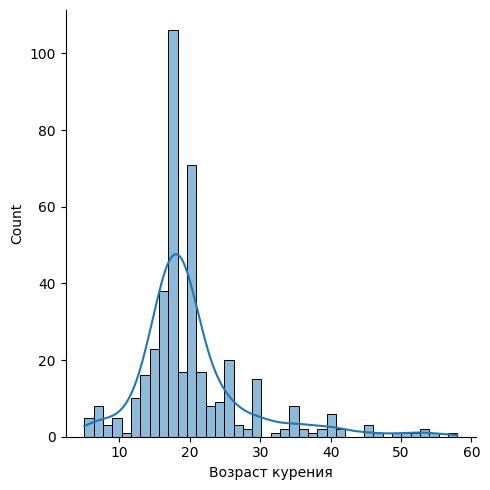

In [132]:
import seaborn as sns
sns.displot(df["Возраст курения"], kde=True) # Возможно кто-то из отвечаюих понял это как "Продолжительность курения"

In [351]:
import cmath


def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.set_index("ID")
    df["Пол"] = df["Пол"].fillna(df["Пол"].mode()[0])
    df = df.drop("ID_y", axis=1)
    df = process_smoking(df)
    df = process_passive_smoking(df)
    df = process_sleeping(df)
    df = df.drop(
        "Возраст алког", axis=1
    )  # Сложно применить без знания возраста отвечающего
    return df


def process_smoking(df: pd.DataFrame) -> pd.DataFrame:
    rating_map = {
        "Никогда не курил(а)": 0.0,
        "Бросил(а)": 0.5,
        "Курит": 1.0,
    }
    df["Статус Курения"] = df["Статус Курения"].map(lambda x: rating_map[x])
    df = df.drop(
        "Возраст курения", axis=1
    )  # Сложно применить без знания возраста отвечающего

    mean_cigs = df["Сигарет в день"].mean()

    def replace_cigs_num(row):
        if not cmath.isnan(row["Сигарет в день"]):
            val = row["Сигарет в день"]
        elif row["Статус Курения"] == "Курит":
            val = mean_cigs
        elif row["Статус Курения"] == "Бросил(а)":
            val = mean_cigs * 0.5
        else:
            val = 0.0
        row["Сигарет в день"] = val
        return row

    df = df.apply(lambda row: replace_cigs_num(row), axis=1)
    return df


def process_passive_smoking(df: pd.DataFrame) -> pd.DataFrame:
    pass_smoking_map = {
        "1-2 раза в неделю": 1.0 / 5.0,
        "3-6 раз в неделю": 2.0 / 5.0,
        "не менее 1 раза в день": 3.0 / 5.0,
        "2-3 раза в день": 4.0 / 5.0,
        "4 и более раз в день": 5.0 / 5.0,
    }
    df["Частота пасс кур"] = df["Частота пасс кур"].map(
        lambda x: pass_smoking_map[x] if isinstance(x, str) else x
    )
    pass_smoking_mean = df["Частота пасс кур"].mean()

    def replace_pass_smoking(row):
        if not cmath.isnan(row["Частота пасс кур"]):
            val = row["Частота пасс кур"]
        elif row["Пассивное курение"] == 1:
            val = pass_smoking_mean
        else:
            val = 0.0
        row["Частота пасс кур"] = val
        return row

    df = df.apply(lambda row: replace_pass_smoking(row), axis=1)
    return df


def process_sleeping(df: pd.DataFrame) -> pd.DataFrame:
    def time_to_hours(x):
        h, s, m = map(int, x.split(":"))
        return h + m / 60 + s / 60 / 60

    start_times = df["Время засыпания"].map(time_to_hours)
    # Для расположения времени до полночи и после рядом
    df["Время засыпания"] = (start_times + 11) % 24
    end_times = df["Время пробуждения"].map(time_to_hours)
    df["Время пробуждения"] = end_times
    sleep_duration = ((end_times - start_times) % 24).rename("Продолжительность сна")
    df = pd.concat([df.iloc[:, :-5], sleep_duration, df.iloc[:, -5:]], axis=1)
    return df


In [312]:
pd.concat([df.iloc[:, :-5], df.iloc[:, -5:]], axis=1)


,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,...,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",ID_y,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,...,06:00:00,0,0,0,54-102-358-02,0,0,0,0,0
1,54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,...,04:00:00,1,0,0,54-103-101-01,1,1,0,0,0
2,54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,...,07:00:00,0,0,0,54-501-026-03,0,0,0,0,0
3,54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,...,07:00:00,0,0,0,54-501-094-02,1,0,0,0,0
4,54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,...,06:00:00,0,0,0,54-503-022-01,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,54-103-006-01,М,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,операторы и монтажники установок и машинного о...,1,0,...,06:00:00,0,0,0,54-103-006-01,0,0,0,0,0
951,54-701-039-01,Ж,вдовец / вдова,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,...,07:15:00,0,0,0,54-701-039-01,0,0,0,0,0
952,54-002-014-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,служащие,0,1,...,08:00:00,1,0,0,54-002-014-01,1,0,1,0,0
953,54-501-022-01,Ж,в браке в настоящее время,европейская,Русские,Атеист / агностик,5 - ВУЗ,"представители законодат. органов власти,...",1,0,...,08:30:00,0,1,0,54-501-022-01,0,0,0,0,0


In [158]:
def replace_smoking(row):
    if not cmath.isnan(row["Сигарет в день"]):
        val = row["Сигарет в день"]
    elif row["Статус Курения"] == "Курит":
        val = df["Сигарет в день"].mean()
    elif row["Статус Курения"] == "Бросил(а)":
        val = df["Сигарет в день"].mean() * 0.5
    else:
        val = 0.0
    row["Сигарет в день"] = val
    return row

df.apply(lambda row: replace_smoking(row), axis=1)

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,...,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",ID_y,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,...,06:00:00,0,0,0,54-102-358-02,0,0,0,0,0
1,54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,...,04:00:00,1,0,0,54-103-101-01,1,1,0,0,0
2,54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,...,07:00:00,0,0,0,54-501-026-03,0,0,0,0,0
3,54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,...,07:00:00,0,0,0,54-501-094-02,1,0,0,0,0
4,54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,...,06:00:00,0,0,0,54-503-022-01,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,54-103-006-01,М,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,операторы и монтажники установок и машинного о...,1,0,...,06:00:00,0,0,0,54-103-006-01,0,0,0,0,0
951,54-701-039-01,Ж,вдовец / вдова,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,...,07:15:00,0,0,0,54-701-039-01,0,0,0,0,0
952,54-002-014-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,служащие,0,1,...,08:00:00,1,0,0,54-002-014-01,1,0,1,0,0
953,54-501-022-01,Ж,в браке в настоящее время,европейская,Русские,Атеист / агностик,5 - ВУЗ,"представители законодат. органов власти,...",1,0,...,08:30:00,0,1,0,54-501-022-01,0,0,0,0,0


In [314]:
df = preprocess(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 955 entries, 54-102-358-02 to 54-702-016-01
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Пол                                    955 non-null    object 
 1   Семья                                  955 non-null    object 
 2   Этнос                                  955 non-null    object 
 3   Национальность                         955 non-null    object 
 4   Религия                                955 non-null    object 
 5   Образование                            955 non-null    object 
 6   Профессия                              955 non-null    object 
 7   Вы работаете?                          955 non-null    int64  
 8   Выход на пенсию                        955 non-null    int64  
 9   Прекращение работы по болезни          955 non-null    int64  
 10  Сахарный диабет                        955 non-null    in

In [315]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-5]
y = df.iloc[:, -5:]
cat_features = set(X.columns)
cat_features.difference_update(
    {
        "Переломы",
        "Травмы за год",
        "Возраст курения",
        "Статус Курения",
        "Сигарет в день",
        "Возраст алког",
        "Частота пасс кур",
        "Продолжительность сна",
        "Время пробуждения",
        "Время засыпания",
    }
)
cat_features = list(cat_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [376]:
import catboost

cb = catboost.CatBoostClassifier(
    cat_features=cat_features,
    loss_function="MultiCrossEntropy",
    custom_metric=["Recall"],
    eval_metric="HammingLoss",
    class_names=list(y_test.columns),
)
cb.fit(X=X_train, y=y_train, eval_set=(X_test, y_test), plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.029651
0:	learn: 0.1253927	test: 0.1486911	best: 0.1486911 (0)	total: 19.6ms	remaining: 19.6s
1:	learn: 0.1256545	test: 0.1486911	best: 0.1486911 (0)	total: 34.2ms	remaining: 17.1s
2:	learn: 0.1308901	test: 0.1570681	best: 0.1486911 (0)	total: 41.8ms	remaining: 13.9s
3:	learn: 0.1335079	test: 0.1560209	best: 0.1486911 (0)	total: 48.8ms	remaining: 12.1s
4:	learn: 0.1246073	test: 0.1528796	best: 0.1486911 (0)	total: 76.4ms	remaining: 15.2s
5:	learn: 0.1243455	test: 0.1560209	best: 0.1486911 (0)	total: 88.7ms	remaining: 14.7s
6:	learn: 0.1238220	test: 0.1539267	best: 0.1486911 (0)	total: 96.3ms	remaining: 13.7s
7:	learn: 0.1227749	test: 0.1560209	best: 0.1486911 (0)	total: 103ms	remaining: 12.8s
8:	learn: 0.1230366	test: 0.1623037	best: 0.1486911 (0)	total: 132ms	remaining: 14.6s
9:	learn: 0.1178010	test: 0.1539267	best: 0.1486911 (0)	total: 160ms	remaining: 15.8s
10:	learn: 0.1196335	test: 0.1560209	best: 0.1486911 (0)	total: 174ms	remaining: 15.6s
11:	learn: 0.120

In [377]:
cb.best_score_

{'learn': {'Recall:class=3': 0.9452054794520548,
  'MultiCrossEntropy': 0.06955757522673388,
  'Recall:class=4': 0.9508196721311475,
  'Recall:class=2': 0.9680851063829787,
  'Recall:class=1': 1.0,
  'HammingLoss': 0.0062827225130890054,
  'Recall:class=0': 0.9654178674351584},
 'validation': {'Recall:class=3': 0.0,
  'MultiCrossEntropy': 0.37881946060840466,
  'Recall:class=4': 0.0,
  'Recall:class=2': 0.0,
  'Recall:class=1': 0.0,
  'HammingLoss': 0.13717277486910995,
  'Recall:class=0': 0.8484848484848485}}

In [378]:
from sklearn.metrics import classification_report
for pred, real, name in zip(zip(*cb.predict(X_test)), zip(*y_test.values), y_test.columns):
    print(name)
    print(classification_report(real, pred))

Артериальная гипертензия
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        92
           1       0.76      0.74      0.75        99

    accuracy                           0.74       191
   macro avg       0.74      0.74      0.74       191
weighted avg       0.74      0.74      0.74       191

ОНМК
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       180
           1       0.00      0.00      0.00        11

    accuracy                           0.94       191
   macro avg       0.47      0.50      0.49       191
weighted avg       0.89      0.94      0.91       191

Стенокардия, ИБС, инфаркт миокарда
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       168
           1       0.00      0.00      0.00        23

    accuracy                           0.88       191
   macro avg       0.44      0.50      0.47       191
weighted 

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classif